In [1]:
import sys
sys.path.insert(0, '..')


In [3]:
from database.dataset import INBreast_Dataset
from mc_detection.hough_mc import HoughCalcificationDetection
from general_utils.metrics import circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show2, simple_im_show
from pathlib import Path
from tqdm import tqdm
import cv2


In [4]:
# # disables all tqdms for testing

# from tqdm import tqdm
# from functools import partialmethod

# tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)


In [5]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_size_mm=2.0,
    extract_patches=False,
    extract_patches_method='all',  # 'centered'
    patch_size=256,
    stride=256,
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,

    return_indexes_in_mask=True)


In [6]:
dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}

hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}

back_ext_radius = 50  # the bigger the more time it takes but the better sens and spec

erosion_iter = 30
erosion_size = 6


hd = HoughCalcificationDetection(dehazing_params, back_ext_radius,
                                 Path.cwd().parent / 'data/hough_img',
                                 hough1_params, hough2_params,
                                 erosion_iter=erosion_iter,
                                 erosion_size=erosion_size)


In [7]:
h1_res = []
h2_res = []

idx = 81
for idx in tqdm(range(len(db))):
    mask = db[idx]['lesion_mask']
    image = db[idx]['img']
    image_id = db.df.iloc[idx].img_id
    true_bboxes = db[idx]['lesion_bboxes']

    processed_image, h1_circles, h2_circles = hd.predict(
        image, image_id, load_processed_images=True)

    TP, FP, FN = circle_comparison(true_bboxes, h1_circles, mask)
    h1_res.append({'image_id':image_id, 'TP': len(TP), 'FP': len(FP), 'FN': FN})

    TP, FP, FN = circle_comparison(true_bboxes, h2_circles, mask)
    h2_res.append({'image_id': image_id, 'TP': len(TP), 'FP': len(FP), 'FN': FN})

100%|██████████| 313/313 [2:19:52<00:00, 26.81s/it]  


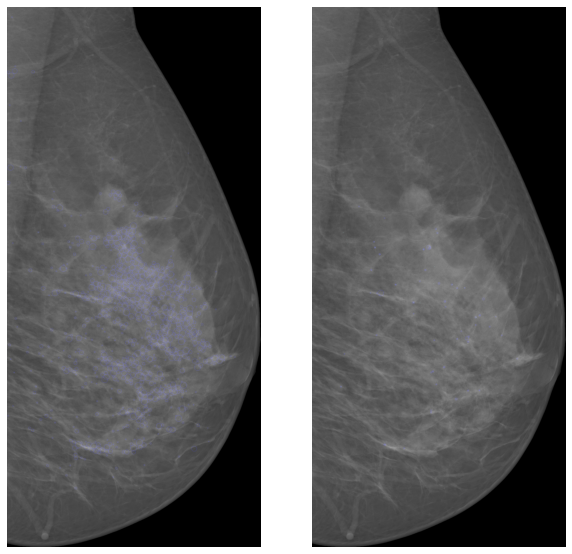

In [18]:
hough_1_res = plot_bboxes_over_image(image, [h1_circles, true_bboxes], [
                                     (0, 0, 255), (0, 255, 255)], ['circ', 'rect'])
cv2.imwrite("hough_1_res.png", hough_1_res)

hough_2_res = plot_bboxes_over_image(image, [h2_circles, true_bboxes], [
    (0, 0, 255), (0, 255, 255)], ['circ', 'rect'])
cv2.imwrite("hough_2_res.png", hough_2_res)


simple_im_show2(hough_1_res, hough_2_res)


In [23]:
h1_res_df = pd.DataFrame(h1_res).set_index('image_id')
h1_res_df['sensitivity'] =  h1_res_df.TP/(h1_res_df.TP + h1_res_df.FN)
h1_res_df['f1'] =  h1_res_df.TP/(h1_res_df.TP + 0.5*(h1_res_df.FN + h1_res_df.FP))

h2_res_df = pd.DataFrame(h2_res).set_index('image_id')
h2_res_df['sensitivity'] =  h2_res_df.TP/(h2_res_df.TP + h2_res_df.FN)
h2_res_df['f1'] =  h2_res_df.TP/(h2_res_df.TP + 0.5*(h2_res_df.FN + h2_res_df.FP))

merged_df = h1_res_df.join(h2_res_df, lsuffix='_h1', rsuffix='_h2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

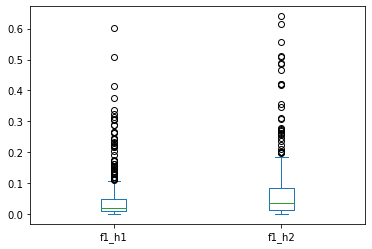

In [24]:
merged_df[['f1_h1', 'f1_h2']].plot.box()

<AxesSubplot:>

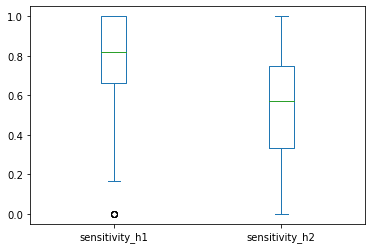

In [25]:
merged_df[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<IPython.core.display.Javascript object>

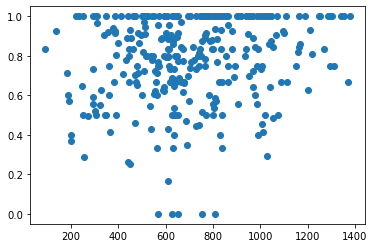

In [30]:
plt.scatter(h1_res_df.FP.values, h1_res_df.sensitivity.values)

<AxesSubplot:ylabel='Frequency'>

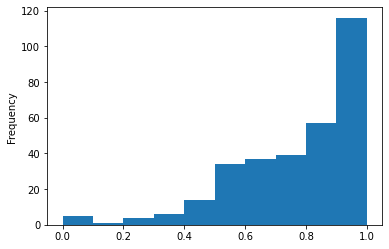

In [90]:
h1_res_df.sensitivity.plot.hist()

In [34]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny

In [85]:
# # Load picture and detect edges
# edges = canny(processed_image, sigma=2, mask=(image!=0))


# Detect two radii
hough_radii = np.arange(1, 21, 1)
hough_res = hough_circle(processed_image, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, min_xdistance=10, min_ydistance=10,
                                           total_num_peaks=10)

h1_alt = np.vstack([cx, cy, radii]).T

TP, FP, FN = circle_comparison(true_bboxes, h1_alt, mask)
print({'image_id':image_id, 'TP': len(TP), 'FP': len(FP), 'FN': FN})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'image_id': 53587717, 'TP': 1, 'FP': 7, 'FN': 7}


In [61]:
h1_alt = np.vstack([cx, cy, radii]).T

TP, FP, FN = circle_comparison(true_bboxes, h1_alt, mask)
print({'image_id':image_id, 'TP': len(TP), 'FP': len(FP), 'FN': FN})

<IPython.core.display.Javascript object>

In [81]:
edges

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

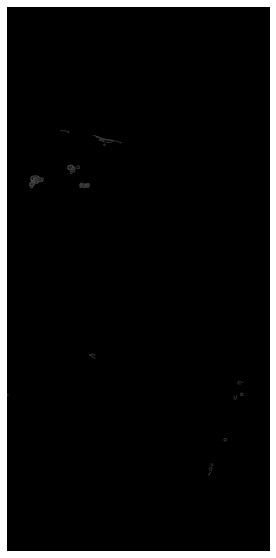

In [82]:
simple_im_show(edges)